In [1]:
# 개와 고양이 이진분류 예제를 EfficientNet을 이용해서 구현
# Tensorflow Keras에서는 EfficientNet을 공식적으로 지원하고 있어요!

# EfficientNet은 버전이 여러개가 있어요!
# EfficientNetB0 ~ B7까지 버전이 있어요!
# B0 :가장 간단한 모델이고 빠르게 학습이 될 수 있어요!
# 일반적으로 B3~B4를 사용. B5 이상은 시간이 오래걸리지만 정확도가 높아요!
# EfficientNetV2B0~B3까지 개량된 모델도 있어요!
# 내가 가지고 있는 이미지의 크기와 살짝 연관성이 있어요!
# EfficientNet 사용할 때 입력 이미지의 크기는 고정시켜서 사용하는게 좋아요!
# 우리는 EfficientNetB4를 사용할거기 때문에 입력 이미지의 크기는 380*380으로 설정할 거에요!
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# float16과 float32를 적절히 섞어서 학습속도를 높이고 
# GPU의 메모리 사용량을 줄일 수 있어요!
# 이렇게 하면 모든 연산이 float16으로 계산되고
# 맨 마지막 output layer만 float32 사용
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU, compute capability 8.6


In [2]:
# 입력데이터 처리
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'

# Parameter 설정
IMAGE_SIZE = 380
BATCH_SIZE = 64 # OOM 오류가 발생하면 숫자를 줄여야 해요!
LEARNING_RATE = 1e-5 # EfficientNet은 상당히 민감한 모델이에요.
                    # learning_rate에 영향을 많이 받는 모델이에요.
                    # 따라서 이 값이 크면 불안정해져요!
                    # 일반적으로 사용하는 값보다 작게 잡는게 좋아요!

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
# Model

pretrained_network = EfficientNetB4(weights='imagenet',
                                    include_top=False,
                                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
# pretrained_network.trainable=False # 이렇게 하는게 맞긴한데... 간혹 동결이 풀리는 경우가 있어요!
for layer in pretrained_network.layers:
    layer.trainable = False
# pretrained_network.summary()

model = Sequential()

model.add(pretrained_network)
# model.add(Flatten()) # 12 * 12 * 1792 
model.add(GlobalAveragePooling2D()) # 12 * 12 * 1792 -> 1 * 1792
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=1,
                activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 12, 12, 1792)      17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                114752    
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                        

In [4]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

cp_callback = ModelCheckpoint(filepath='./EfficientNet.weights.h5',
                              save_best_only=True,
                              save_weights_only=True,
                              monitor='val_accuracy',
                              verbose=1)
es_callback = EarlyStopping(monitor='val_loss',
                            patience=5,
                            restore_best_weights=True,
                            verbose=1)

In [ ]:
# 1차 학습
model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=20,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[cp_callback, es_callback],
          verbose=1)
# Epoch 20: val_accuracy did not improve from 0.99500
# 32/32 [==============================] - 35s 1s/step - 
# loss: 0.1235 - accuracy: 0.9810 - val_loss: 0.0867 - val_accuracy: 0.9940

In [ ]:
# Fine Tuning

for layers in pretrained_network.layers:
    layer.trainable = True

for layers in pretrained_network.layers[:-30]:
    layer.trainable = False

# 반드시 다시 compile 작업을 해야해요!
# learning_rate는 줄여서 사용해야 하구요!
# optimizer(Adam)도 새롭게 생성해서 사용해야 해요!
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE * 0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 재학습 (epoch 수는 조금 증가시키는게 일반적)
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[cp_callback, es_callback],
                    verbose=1)
# Epoch 30: val_accuracy did not improve from 0.99500
# 32/32 [==============================] - 33s 1s/step - 
# loss: 0.1003 - accuracy: 0.9845 - val_loss: 0.0705 - val_accuracy: 0.9950

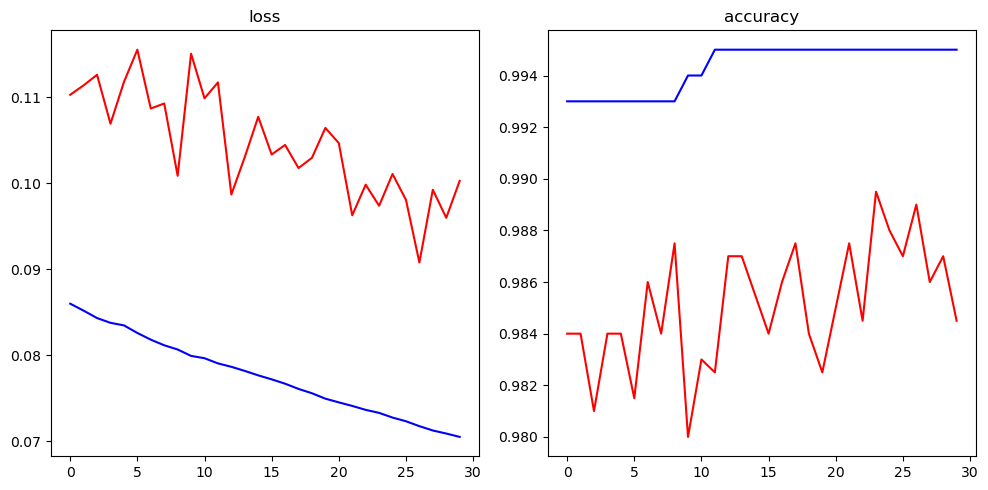

In [8]:
# 그래프
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()

plt.show()